### 순환 신경망

- 순환 신경망(RNN) : 뉴런을 통과한 출력이 다음 입력이 들어오면 그 입력과 함께 사용됨

- 타임스텝 : 샘플을 처리하는 한 단계

- 은닉상태 : 셀의 출력

- RNN의 활성화 함수 : tanh 함수(자연어 처리에서 많이 활용)

## 순환 신경망으로 IMDB 리뷰 분류

In [1]:
import tensorflow as tf

In [2]:
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

### IMDB 리뷰 데이터셋 로드

- 텍스트 데이터 : 단어를 숫자로 바꾸고 단어마다 고유한 정수 부여

- 토큰 : (영어) 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리. 간단한 문제에서는 단어와 같게봐도 무방.

- 1개의 토큰이 하나의 타임스탬프

- 토큰에서 예약된 정수 : 0 패딩 / 1 문장의 시작 / 2는 어휘 사전에 없는 토큰(어휘사전 : 훈련세트에서 고유한 단어를 뽑아 만든 목록)

In [21]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words = 500) 

# num_words : 전체 데이터셋에서 가장 자주 등장하는 단어 500개만 사용
# IMDB 리뷰 텍스트는 길이 제각각이라 2차원 배열에 담지 않고 리뷰마다 별도의 파이썬 리스트로 담음
# 해결해야 될 문제 : 리뷰가 부정(0) ? 긍정(1) ?

In [22]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [8]:
print(len(train_input[0]))

218


In [9]:
print(len(train_input[1]))

189


In [12]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [7]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [23]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size= 0.2, random_state=42
)

In [24]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

In [25]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


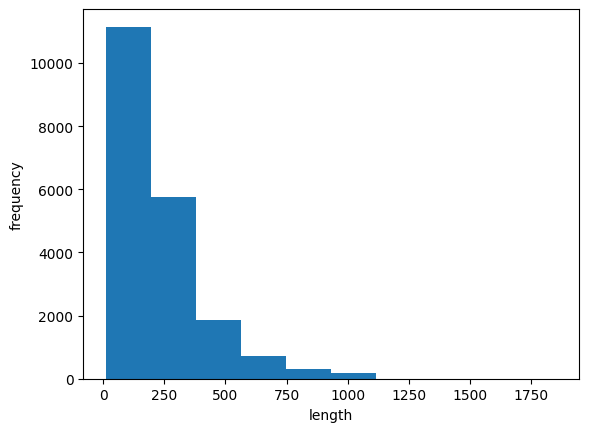

In [26]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

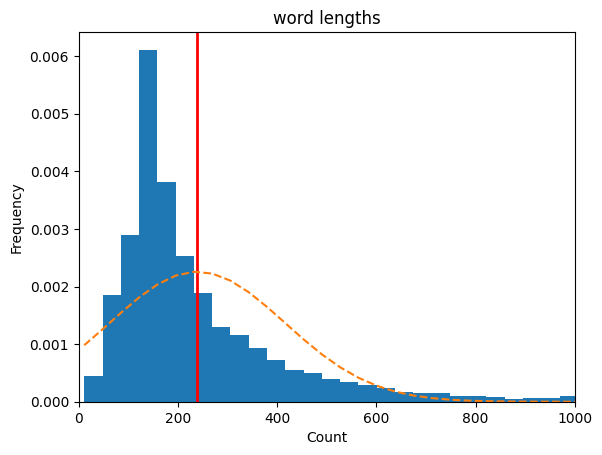

In [43]:
avg = np.mean(lengths)
tan = np.std(lengths)

nbins = 50
n, bins, patches = plt.hist(lengths, bins = nbins, density=1)
plt.xlim(0,1000,200)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('word lengths')
plt.axvline(x = np.mean(lengths), linewidth =2, color = 'r')
y = ((1 / (np.sqrt(2 * np.pi) * tan)) * np.exp(-0.5 * (1/tan * (bins - avg))**2))
plt.plot(bins,y,'--')
plt.show()

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen = 100)
print(train_seq.shape)

(20000, 100)


- pad_sequences는 기본적으로 문서의 뒤에 0을 채우는 것이 아니라 앞에 0으로 채우기 때문

In [28]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [29]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [31]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [32]:
val_seq= pad_sequences(val_input, maxlen = 100)

### 순환 신경망 만들기